In [1]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from MVAE import *
import cv2 

ModuleNotFoundError: No module named 'pytorch_lightning'

In [2]:
device = torch.device(1 if torch.cuda.is_available() else 0)
device

device(type='cuda', index=1)

In [3]:
TRAIN_MASK_DIR = './train/'

# Alternate Custom DataSet

In [8]:
import pandas as pd
from PIL import Image
import os
import cv2 

In [9]:
dataSetDIR = f"D:\_0Luciano\_0PHD\datasets"
masksDir =  f'D:\_0Luciano\_0PHD\datasets\masks10-90'

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        filename = self.img_labels.iloc[idx, 0] + '.png'
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [10]:
transform = transforms.Compose([transforms.Resize((64 , 64)),
                                transforms.Grayscale(num_output_channels=1)
                                ,transforms.ToTensor()])
masksDS = CustomImageDataset('./saltMaskOk.csv',masksDir,transform)

In [11]:
dataloaderCustomDS = DataLoader(masksDS, batch_size=64, shuffle=True)

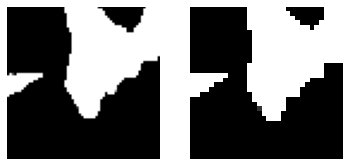

In [110]:
tensorImg = masksDS[6][0]
numpyImg = tensorImg.numpy()[0]
mPooling = skimage.measure.block_reduce(numpyImg, (2,2), np.max) 
plt.figure()
plt.subplot(1, 2, 1); plt.imshow(numpyImg,  cmap='gray');  plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(mPooling,cmap = 'gray' ); plt.axis('off')
plt.show()

torch.Size([64, 1, 64, 64])


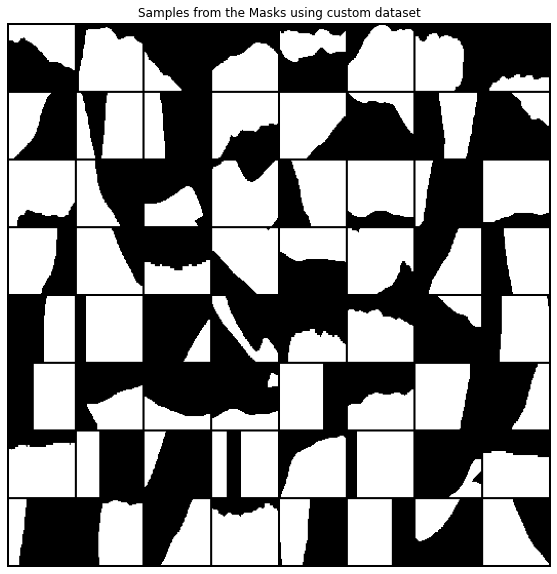

In [123]:
it=iter(dataloaderCustomDS)
real_batch = next(iter(it))
plt.figure(figsize=(10,10))
print(real_batch[0].size())
plt.imshow(np.transpose(utils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)),cmap='gray')
plt.axis('off')
plt.title('Samples from the Masks using custom dataset');
plt.show()

# Treinamento

In [14]:
Decoders = nn.ModuleList([Decoder_MLP(latent_dim=100, in_channel=1, im_size=64, hiddens=[256, 512, 1024])])
MabVae = MabVAE(dataloaderCustomDS, Decoders, eps=0.3, i=0)
trainer = Trainer(gpus=1, max_epochs=20)

In [16]:
trainer.fit(MabVae)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | decoders | ModuleList | 4.9 M 
1 | encoder  | Encoder    | 8.0 M 
----------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.653    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 26/26 [00:04<00:00,  5.72it/s, loss=4.09e+06, v_num=49]


In [17]:
MabVae.NbDraws/torch.sum(MabVae.NbDraws)

tensor([1.], device='cuda:0')

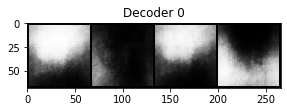

In [59]:
fixed_noise=torch.randn(4,100)
plt.figure(figsize=(10,10))
for i,decoder in enumerate(Decoders):
  fake=decoder(fixed_noise).detach()
  plt.subplot(3,2,i+1)
  plt.title(f'Decoder {i}')
  plt.imshow(np.transpose(utils.make_grid(fake,padding=2,normalize=True).cpu(),(1,2,0)))

plt.savefig(f'Decoders_MASK.png')

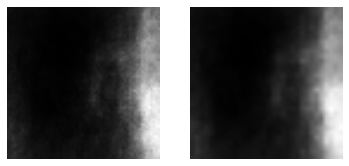

In [120]:
img = fake[0]
npyImg = img.numpy()[0]
mPooling = skimage.measure.block_reduce(npyImg, (2,2), np.max) 
fig, ax = plt.subplots(1, 2)
ax[0].axis('off')
ax[0].imshow(npyImg, interpolation='bilinear', cmap= 'gray' );  
ax[1].imshow(mPooling,  interpolation='bilinear', cmap='gray'); 
ax[1].axis('off')
plt.show()

(-0.5, 529.5, 529.5, -0.5)

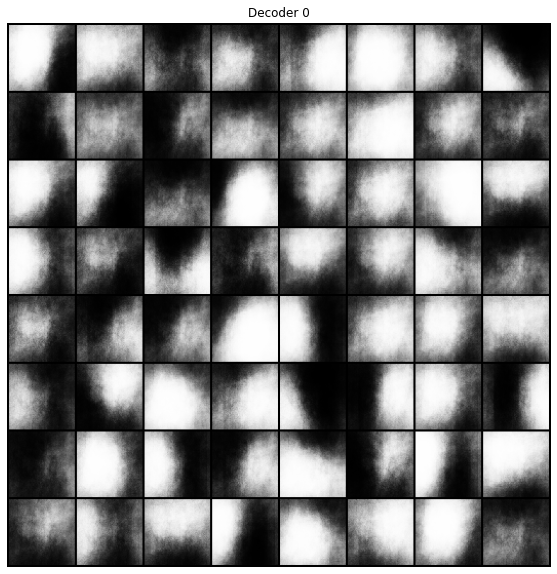

In [121]:
samples = 64
MLP= Decoders[0]
fixed_noise=torch.randn(samples,100)

plt.figure(figsize=(10,10))
fake=MLP(fixed_noise).detach()
plt.title(f'Decoder {i}')
plt.imshow(np.transpose(utils.make_grid(fake,padding=2,normalize=True).cpu(),(1,2,0)))
plt.axis('off')

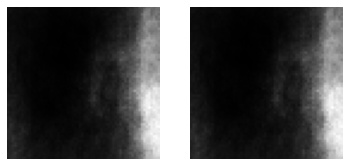

In [114]:
ìmg = fake[5][0]
tensorImg = img
tensorImg

plt.figure()
plt.subplot(1, 2, 1); plt.imshow(npyImg,  cmap='gray');  plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(img.numpy()[0],cmap = 'gray' ); plt.axis('off')
plt.show()